<a href="https://colab.research.google.com/github/nhanguyenai/ModelPredictFlower/blob/main/ModelPredictFlower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import glob
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow.keras as keras

# 1. Mount Google Drive (for Colab)
from google.colab import drive
drive.mount('/content/drive')

# 2. Define paths
dataset_path = '/content/drive/My Drive/'

# 3. Define specific flower names
specific_flowers = ['hoacuc', 'hoavang']

# 4. Filter and organize dataset
image_paths = []
labels = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".jpg"):
            file_path = os.path.join(root, file)
            # Extract the label, if needed, from the file name
            # Check if any of the specific flower names are in the file path
            for flower in specific_flowers:
                if flower in file_path:
                    image_paths.append(file_path)
                    labels.append(flower)  # Use the flower name as the label
                    break  # Move to the next file if a flower is found
            else:
                # Handle files that don't contain any of the specific flower names
                print(f"Skipping file: {file_path} (does not contain any of the specified flowers)")

# Check if any images were found
if len(image_paths) == 0:
    print("No images found matching your criteria. Please check your dataset path and file names.")
else:
    # 5. Create DataFrame for data organization
    df = pd.DataFrame({'filename': image_paths, 'class': labels})

    # 6. Split dataset
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

    # ... (rest of your code) ...

# 7. Image preprocessing
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),  # Reduced image size
    class_mode='categorical',
    batch_size=32,
    subset='training'
)
validation_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),  # Reduced image size
    class_mode='categorical',
    batch_size=32,
    subset='validation'
)
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=(128, 128),  # Reduced image size
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

# 8. Build a simpler model
model = Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(len(specific_flowers), activation='softmax')  # Output layer
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 9. Train the model with reduced epochs
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5  # Reduced epochs for faster training
)

# 10. Save the model
model.save("flower.h5")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1165 validated image filenames belonging to 2 classes.
Found 291 validated image filenames belonging to 2 classes.
Found 365 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.5309 - loss: 2.8447 - val_accuracy: 0.6804 - val_loss: 0.5725
Epoch 2/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 204ms/step - accuracy: 0.7102 - loss: 0.5624 - val_accuracy: 0.7388 - val_loss: 0.5310
Epoch 3/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 192ms/step - accuracy: 0.7810 - loss: 0.4501 - val_accuracy: 0.7629 - val_loss: 0.5370
Epoch 4/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - accuracy: 0.9199 - loss: 0.2613 - val_accuracy: 0.7629 - val_loss: 0.5706
Epoch 5/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step - accuracy: 0.9448 - loss: 0.1749 - val_accuracy: 0.7285 - val_loss: 0.6962


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step
Xác suất của các lớp: [[0.7686772  0.23132278]]
Dự đoán nhãn: hoacuc


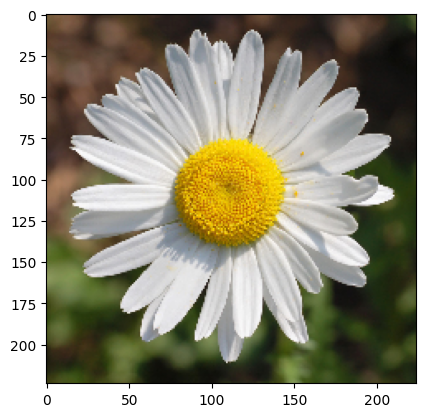

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
from google.colab import drive
import os

# 🚀 Load mô hình từ file .h5
model_path = '/content/flower.h5'
model = tf.keras.models.load_model(model_path)

# 🖼️ Hàm tải và dự đoán ảnh từ file
def predict_image(img_path, model):
    # Tải ảnh và resize lại cho phù hợp với mô hình
    img = image.load_img(img_path, target_size=(224, 224))  # Changed target_size to (224, 224)
    img_array = image.img_to_array(img)  # Chuyển ảnh thành mảng numpy
    img_array = np.expand_dims(img_array, axis=0)  # Thêm batch dimension
    img_array = img_array / 255.0  # Normalize ảnh

    # Dự đoán ảnh
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)

    return predictions, predicted_class

# 📁 Chọn file ảnh để dự đoán
img_path = '/content/hoacuctest.jpg'  # Đường dẫn ảnh cần dự đoán

# Call the predict_image function to get predictions and predicted label
predictions, predicted_label = predict_image(img_path, model) # call the function and store the returned values in these variables

# Hiển thị ảnh và kết quả dự đoán
img = image.load_img(img_path, target_size=(224, 224))  # Changed target_size to (224, 224)
plt.imshow(img)

# In ra xác suất của các lớp
print(f"Xác suất của các lớp: {predictions}")
# predicted_label is a numerical index, you likely want to map it back to your specific_flowers
print(f"Dự đoán nhãn: {specific_flowers[predicted_label[0]]}") # index into your flower list